<a href="https://www.kaggle.com/code/ryanlliu/baseline-model?scriptVersionId=160723417" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Recap: EDA
- 78 Video:
  - 6224 frame images
  - 6224 mask images (pixels in image = [0, 7, 8])
  - 6224 mask enhance images (pixels in image are scaled to [0,255])
- The processed size is 1295x1026
- Frame label count: (6, 3743), (5, 1136), (3, 1022), (4, 323)
  - Label 3-None, 4-OnlySP, 5-OnlyHead, 6-SP+Head in framelabel.csv

In [1]:
import os
import random
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

# for read img
from PIL import Image
import cv2

from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


To ensure the reproducibility, we will control the seed of random generators

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Prepare dataset

In [3]:
dataset_path = '/kaggle/input/jnu-ifm-for-segment-pubic-symphysis-fetal-head/dataset'
print(os.listdir(dataset_path))

img_paths = os.listdir(f'{dataset_path}/image')
mask_paths = os.listdir(f'{dataset_path}/enhance_mask')

print(f'{len(img_paths)} frame images')
print(f'{len(mask_paths)} mask images')

['enhance_mask', 'frame_label.csv', 'mask', 'image']
6224 frame images
6224 mask images


In [4]:
# Mapping 1-1 between mask and image
imgs = [img.replace("_mask", "") for img in mask_paths]

# Define dataset
- load images and masks, apply transformations, and return them as a dictionary

In [5]:
print(len(imgs))
print(len(mask_paths))

6224
6224


In [6]:
from sklearn.model_selection import train_test_split

train_img, test_img, train_mask, test_mask = train_test_split(imgs, mask_paths, test_size = 0.1, random_state=123)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1, random_state=123)

In [7]:
print(len(train_img))
print(len(val_img))
print(len(test_img))

5040
561
623


Double check image and mask information

Shape = (1026, 1295), uniques value = [  0  76 149]


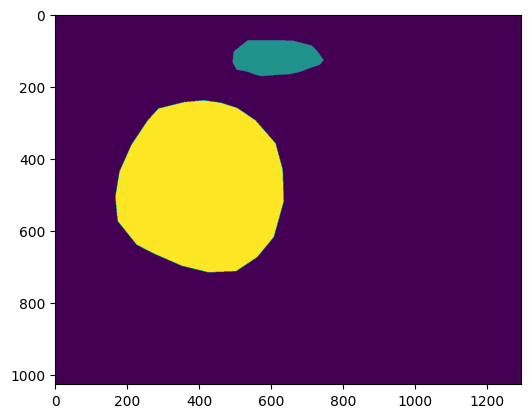

In [8]:
path = f'{dataset_path}/enhance_mask/{train_mask[1]}'
mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
print(f'Shape = {mask.shape}, uniques value = {np.unique(mask.flatten())}')
plt.imshow(mask)
plt.show()

Shape = (1026, 1295, 3), uniques value = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72
  73  74  75  76  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 170 171 172 173 174 175 176 178 179 180 181 182 183 185 186
 187 188 189 190 192 193 194 195 196 197 199 200 201 202 203 204 206 207
 208 209 210 211 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 234 235 236 237 238 239 241 242 243 244 245 246
 248 249 2

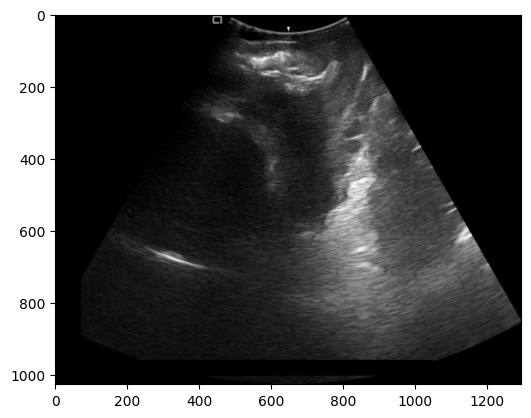

In [9]:
path = f'{dataset_path}/image/{train_img[1]}'
img = cv2.imread(path)
print(f'Shape = {img.shape}, uniques value = {np.unique(img.flatten())}')
plt.imshow(img)
plt.show()

#### Define dataset class

For maintaining the correct proportions when resizing or displaying the content
- we firstly center crop [1024, 12024]
- and then resize to [128, 128]
>> So the content doesn’t get distorted

**Notes**: For mask - need integer values for indexing or categorical representation -> 
Casts the elements of the tensor to the long data type, which is PyTorch's 64-bit integer type

In [10]:
# define dataset class
class SegmentationDataset(Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = f'{dataset_path}/image/{img_name}'
        image = Image.open(img_path).convert('L')

        mask_name = self.masks[idx]
        mask_path = f'{dataset_path}/enhance_mask/{mask_name}'
        mask = Image.open(mask_path).convert('L') # read mask in grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        # scale img and mask
#         scaled_mask = mask * 255  # scale to 255 (else long() -> 0)
#         long_mask = converted_mask.long()  # Convert mask to long tensor
        binary_mask= (mask > 0).long()
        converted_mask = binary_mask.squeeze() # removes redundant dimensions (1, rz, rz) > (rz, rz) 

        return image, converted_mask

#### Define dataset instance

In [11]:
t = T.Compose([
            T.CenterCrop((1024, 1024)),
            T.Resize(size=(128, 128), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor(),
    ])

train_set = SegmentationDataset(train_img, train_mask, transform=t)
val_set = SegmentationDataset(val_img, val_mask, transform=t)
test_set = SegmentationDataset(test_img, test_mask, transform=t)

img, mask = train_set[1]
print(f'{mask.shape}, {torch.unique(mask.flatten())}')

torch.Size([128, 128]), tensor([0, 1])


#### Instantiate dataloaders

In [12]:
b_sz = 8

train_loader = DataLoader(dataset=train_set, batch_size=b_sz, shuffle=True)
val_loader = DataLoader(dataset=train_set, batch_size=b_sz, shuffle=True)
test_loader = DataLoader(dataset=train_set, batch_size=b_sz, shuffle=True)

#### Test dataloaders

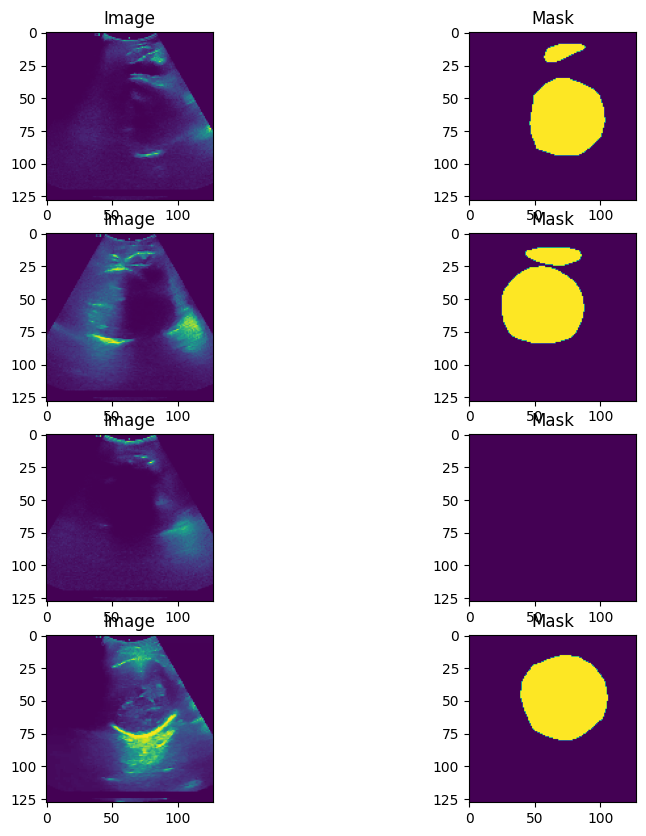

In [13]:
def visualize(loader, n=4):
    # Get a batch of images and masks from the loader
    images, masks = next(iter(loader))

    # Plot the images and masks in a grid
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 10))
    for i in range(n):
        axes[i, 0].imshow(images[i].permute(1, 2, 0)) # show the image
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(masks[i].squeeze()) # show the mask
        axes[i, 1].set_title("Mask")
    plt.show()

# Call the visualize function on the test dataloader
visualize(val_loader)

# Baseline model

In [14]:
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Encoder with downsampling layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Preserve spatial dimensions
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Bottleneck layer for feature extraction
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Decoder with upsampling layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1),  # Final output layer
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        logits = self.decoder(x)
        
#         # Apply softmax along the second dimension (axis=1) to get probabilities
#         softmax_output = nn.functional.softmax(x, dim=1)

#         # Get the index of the maximum probability for each pixel
#         max_indices = torch.argmax(softmax_output, dim=1, keepdim=True)

#         # Map the indices to the specified values
#         mapped_output = torch.where(max_indices == 0, torch.tensor(0),
#                                      torch.where(max_indices == 1, torch.tensor(76),
#                                                  torch.tensor(150)))
        return logits

# Example usage
model = SegmentationModel(num_classes=2)

# Loss function

In [15]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon
    
    def forward(self, y_pred, y_true):
        y_pred = F.softmax(y_pred, dim=1) # Apply a sigmoid function to the prediction
        y_pred = y_pred[:, 1, :, :] # Reshape the tensor to [8, 128, 128]
        
        # Flatten the tensors
        y_true = y_true.reshape(-1)
        y_pred = y_pred.reshape(-1)
        
        # Compute the intersection and the union
        intersection = torch.sum(y_true * y_pred)
        union = torch.sum(y_true) + torch.sum(y_pred)
        
        # Compute the Dice coefficient and return the loss
        dice = (2 * intersection + self.epsilon) / (union + self.epsilon)
        return -torch.log(dice)

## Metrics

In [16]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

# Training

In [17]:
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            # calculation mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'SegmentationModel_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [18]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = DiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.026 
Epoch:1/15.. Train Loss: 1.173.. Val Loss: 1.026.. Train mIoU:0.317.. Val mIoU: 0.448.. Train Acc:0.507.. Val Acc:0.701.. Time: 8.08m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 1.026 >> 0.642 
Epoch:2/15.. Train Loss: 0.849.. Val Loss: 0.642.. Train mIoU:0.505.. Val mIoU: 0.592.. Train Acc:0.754.. Val Acc:0.837.. Time: 6.48m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.642 >> 0.572 
Epoch:3/15.. Train Loss: 0.630.. Val Loss: 0.572.. Train mIoU:0.597.. Val mIoU: 0.627.. Train Acc:0.839.. Val Acc:0.868.. Time: 6.40m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.572 >> 0.478 
saving model...
Epoch:4/15.. Train Loss: 0.522.. Val Loss: 0.478.. Train mIoU:0.641.. Val mIoU: 0.659.. Train Acc:0.866.. Val Acc:0.875.. Time: 6.27m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.478 >> 0.433 
Epoch:5/15.. Train Loss: 0.452.. Val Loss: 0.433.. Train mIoU:0.675.. Val mIoU: 0.676.. Train Acc:0.886.. Val Acc:0.877.. Time: 6.26m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.433 >> 0.367 
Epoch:6/15.. Train Loss: 0.400.. Val Loss: 0.367.. Train mIoU:0.701.. Val mIoU: 0.718.. Train Acc:0.900.. Val Acc:0.908.. Time: 6.24m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.367 >> 0.344 
Epoch:7/15.. Train Loss: 0.361.. Val Loss: 0.344.. Train mIoU:0.721.. Val mIoU: 0.730.. Train Acc:0.909.. Val Acc:0.912.. Time: 6.27m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.344 >> 0.321 
Epoch:8/15.. Train Loss: 0.343.. Val Loss: 0.321.. Train mIoU:0.732.. Val mIoU: 0.745.. Train Acc:0.914.. Val Acc:0.920.. Time: 6.30m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.321 >> 0.302 
saving model...
Epoch:9/15.. Train Loss: 0.314.. Val Loss: 0.302.. Train mIoU:0.748.. Val mIoU: 0.755.. Train Acc:0.921.. Val Acc:0.925.. Time: 6.30m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.302 >> 0.288 
Epoch:10/15.. Train Loss: 0.376.. Val Loss: 0.288.. Train mIoU:0.755.. Val mIoU: 0.763.. Train Acc:0.924.. Val Acc:0.925.. Time: 6.34m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.288 >> 0.274 
Epoch:11/15.. Train Loss: 0.281.. Val Loss: 0.274.. Train mIoU:0.768.. Val mIoU: 0.774.. Train Acc:0.930.. Val Acc:0.934.. Time: 6.28m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.274 >> 0.265 
Epoch:12/15.. Train Loss: 0.269.. Val Loss: 0.265.. Train mIoU:0.776.. Val mIoU: 0.777.. Train Acc:0.933.. Val Acc:0.931.. Time: 6.32m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.265 >> 0.253 
Epoch:13/15.. Train Loss: 0.258.. Val Loss: 0.253.. Train mIoU:0.782.. Val mIoU: 0.786.. Train Acc:0.935.. Val Acc:0.937.. Time: 6.31m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Decreasing.. 0.253 >> 0.250 
saving model...
Epoch:14/15.. Train Loss: 0.253.. Val Loss: 0.250.. Train mIoU:0.786.. Val mIoU: 0.788.. Train Acc:0.937.. Val Acc:0.938.. Time: 6.28m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:15/15.. Train Loss: 0.249.. Val Loss: 0.250.. Train mIoU:0.789.. Val mIoU: 0.789.. Train Acc:0.938.. Val Acc:0.938.. Time: 6.36m
Total time: 96.49 m


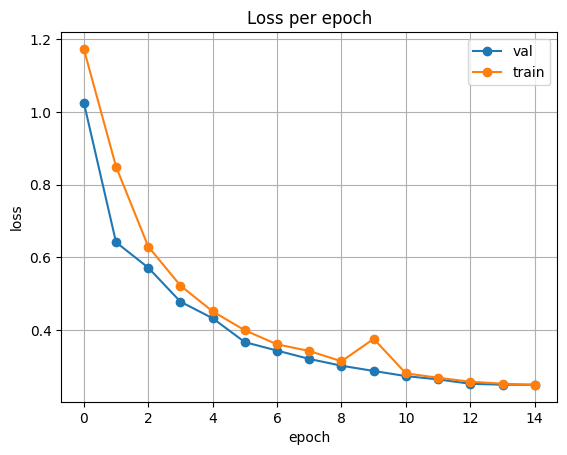

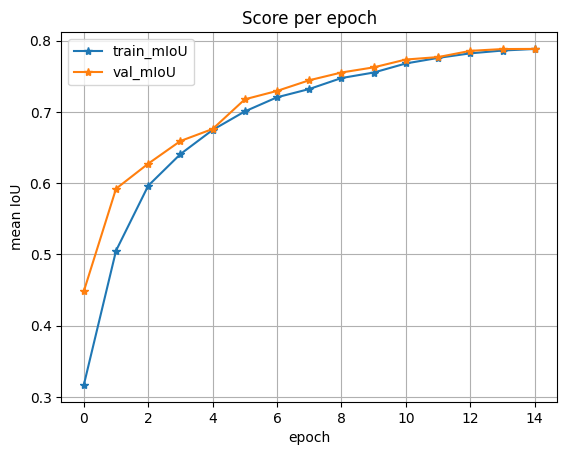

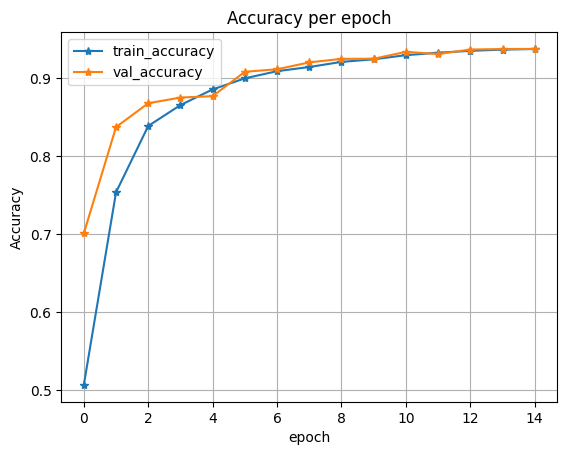

In [19]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
plot_loss(history)
plot_score(history)
plot_acc(history)

# Testing

  0%|          | 0/630 [00:00<?, ?it/s]

Test Loss: 0.24878349135082867
Test mIoU: 0.7891858205716795
Test Accuracy: 0.9376819671146454


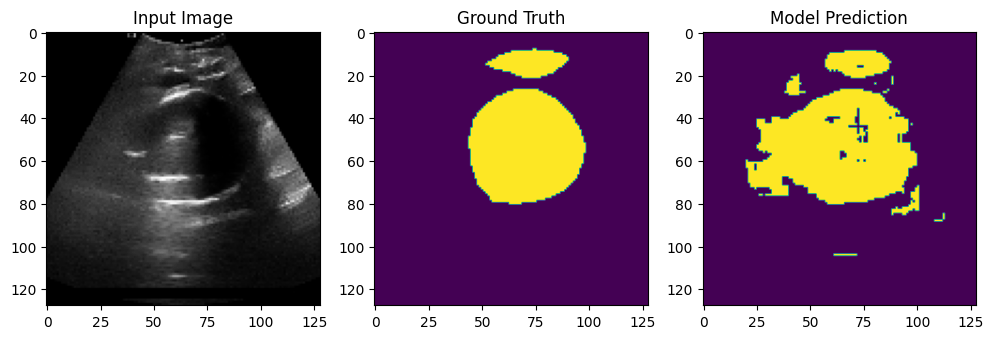

In [20]:
# Test
model.eval()
test_loss = 0.0
test_iou = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for i, data in enumerate(tqdm(val_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate metrics
        test_iou += mIoU(outputs, labels)
        test_accuracy += pixel_accuracy(outputs, labels)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
average_test_iou = test_iou / len(test_loader)
average_test_accuracy = test_accuracy / len(test_loader)

print(f"Test Loss: {average_test_loss}")
print(f"Test mIoU: {average_test_iou}")
print(f"Test Accuracy: {average_test_accuracy}")

# Visualize input, ground truth, and prediction for one example
model.eval()
with torch.no_grad():
    example_inputs, example_labels = next(iter(test_loader))
    example_inputs, example_labels = example_inputs.to(device), example_labels.to(device)
    example_outputs = model(example_inputs)

    # Visualize input, ground truth, and prediction
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(example_inputs[0, 0].cpu().numpy(), cmap='gray')
    plt.title('Input Image')
    plt.subplot(1, 3, 2)
    plt.imshow(example_labels[0].cpu().numpy(), cmap='viridis')
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(torch.argmax(example_outputs[0], dim=0).cpu().numpy(), cmap='viridis')
    plt.title('Model Prediction')
    plt.show()